# Autoformer model for Time Series Forecasting

- 입력 시계열을 두 부분으로 분해:
    - Seasonal Part: 반복적이고 주기적인 패턴
    - Trend-Cyclical Part: 장기 변화와 저주파 요소

- Epoch 30, Loss: 0.0477
- Transformer, Informer에 비해 오래 걸림

### Import libraries

In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing sample time series data

In [3]:
# 랜덤 시드 고정 (재현성 확보)
np.random.seed(42)

# 1. 시계열 데이터 생성 (sin 파형 + 약간의 노이즈)
t = np.arange(0, 500)
data = np.sin(0.05 * t) + 0.1 * np.random.randn(500)
data = data.reshape(-1, 1)  # shape: (500, 1)

# 2. MinMaxScaler로 0~1 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3. 슬라이딩 윈도우 함수 정의
def create_inout_sequences(data, input_window, output_window):
    in_seq, out_seq = [], []
    L = len(data)
    for i in range(L - input_window - output_window):
        train_seq = data[i:i+input_window]
        train_label = data[i+input_window:i+input_window+output_window]
        in_seq.append(train_seq)
        out_seq.append(train_label)
    return np.array(in_seq), np.array(out_seq)

# 4. 윈도우 길이 설정
input_window = 48      # Autoformer Encoder Input
output_window = 24     # Autoformer Decoder Output (예측 대상)

# 5. 입력/출력 데이터 생성
X, y = create_inout_sequences(data_scaled, input_window, output_window)

# 6. Torch Tensor로 변환 (모델 입력에 적합하게)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)  # shape: (batch, 48, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)  # shape: (batch, 24, 1)

In [4]:
# 7. 확인
print("Input tensor shape:", X_tensor.shape)    # (batch, input_window, 1)
print("Target tensor shape:", y_tensor.shape)   # (batch, output_window, 1)

Input tensor shape: torch.Size([428, 48, 1])
Target tensor shape: torch.Size([428, 24, 1])


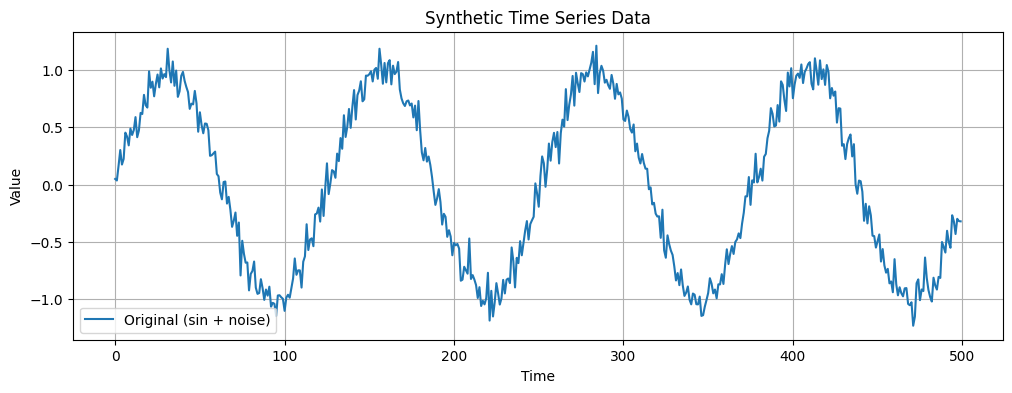

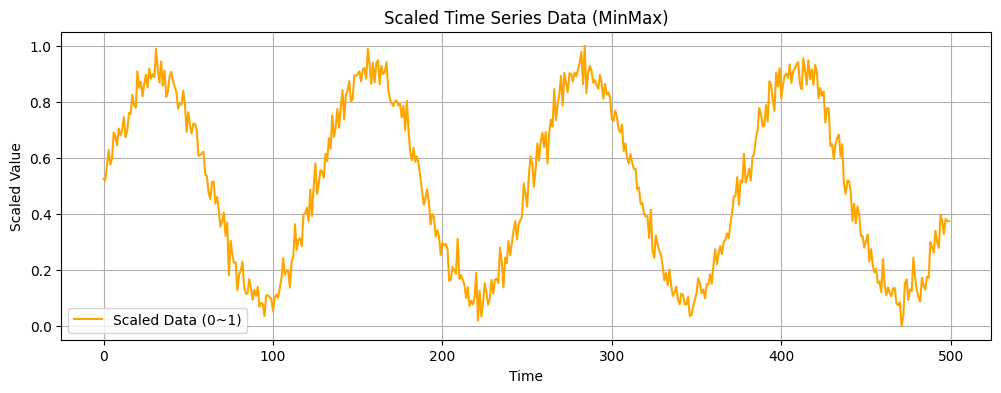

In [5]:
# 시계열 데이터 시각화 (정규화 전 원본)
plt.figure(figsize=(12, 4))
plt.plot(t, data, label="Original (sin + noise)")
plt.title("Synthetic Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# 시계열 데이터 시각화 (MinMaxScaler 적용 후)
plt.figure(figsize=(12, 4))
plt.plot(data_scaled, label="Scaled Data (0~1)", color='orange')
plt.title("Scaled Time Series Data (MinMax)")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.legend()
plt.grid(True)
plt.show()

### Series Decomposition

- Trend + Seasonal 분해
    - Trend: 완만한 흐름
    - Seasonal: 주기적/변동적 패턴

In [6]:
# 이동 평균 연산 정의 (Trend 추출)
class MovingAverage(nn.Module):
    def __init__(self, kernel_size: int):
        super(MovingAverage, self).__init__()
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        # Conv1d를 위해 (batch, d_model, seq_len)로 reshape
        x = x.permute(0, 2, 1)  # (B, D, L)
        x_padded = F.pad(x, (self.padding, self.padding), mode='replicate')
        avg = F.avg_pool1d(x_padded, kernel_size=self.kernel_size, stride=1)
        return avg.permute(0, 2, 1)  # 다시 (B, L, D)로 복원

# 시계열 분해 모듈 (Trend + Seasonal)
class SeriesDecomposition(nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = MovingAverage(kernel_size)

    def forward(self, x):
        trend = self.moving_avg(x)
        seasonal = x - trend
        return seasonal, trend

### Auto-correlation Mechanism

- Self-Attention 대신 Auto-Correlation (자기 상관) 사용

In [7]:
class AutoCorrelation(nn.Module):
    def __init__(self, top_k=5):
        super(AutoCorrelation, self).__init__()
        self.top_k = top_k  # 상위 몇 개 shift만 사용

    def forward(self, queries, keys, values):
        # queries, keys, values: (B, L, D)
        B, L, D = queries.shape

        # 1. Auto-correlation score 계산 (B, L, L)
        scores = torch.matmul(queries, keys.transpose(-2, -1))  # (B, L, L)

        # 2. 평균 score → 각 shift의 대표성 판단 (B, L)
        scores_mean = scores.mean(dim=1)  # (B, L)

        # 3. 상위 top_k shift 선택
        top_k = min(self.top_k, L)
        weights, indices = torch.topk(scores_mean, top_k, dim=-1)  # weights: (B, top_k), indices: (B, top_k)

        # 4. 각 shift에 대해 weighted rolling 합산
        V_shifted = torch.zeros_like(values)  # (B, L, D)
        for i in range(top_k):
            shift = indices[:, i]  # (B,)
            for b in range(B):
                shift_b = int(shift[b].item())
                rolled = torch.roll(values[b], -shift_b, dims=0)  # (L, D)
                weight = weights[b, i].unsqueeze(0).expand_as(rolled)  # (L, D)
                V_shifted[b] += rolled * weight

        # 5. 평균으로 정규화
        V_shifted = V_shifted / top_k

        return V_shifted

### Autoformer EncoderLayer

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, moving_avg_kernel, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.decomp1 = SeriesDecomposition(moving_avg_kernel)
        self.auto_corr = AutoCorrelation()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )

        self.decomp2 = SeriesDecomposition(moving_avg_kernel)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        # 1. 첫 번째 분해
        seasonal_1, _ = self.decomp1(x)

        # 2. Auto-Correlation (Self-Attention 대체)
        x_ac = self.auto_corr(seasonal_1, seasonal_1, seasonal_1)

        # 3. Residual + Dropout + Norm
        x = self.layer_norm1(seasonal_1 + self.dropout(x_ac))

        # 4. Feed Forward Network
        y = self.ffn(x)
        y = self.layer_norm2(x + self.dropout(y))

        # 5. 두 번째 분해
        seasonal_2, trend_2 = self.decomp2(y)

        return seasonal_2, trend_2


### Autoformer Encoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, d_model, moving_avg_kernel, num_layers=2, dropout=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, moving_avg_kernel, dropout)
            for _ in range(num_layers)
        ])
    
    def forward(self, x):
        # trend들을 누적합산할 리스트
        trend_list = []

        # 입력 x를 차례로 통과시키며 seasonal/trend 분리
        for layer in self.layers:
            x, trend = layer(x)         # x: seasonal, trend: residual trend
            trend_list.append(trend)

        # trend를 모두 더함 (decoder에서 사용)
        trend_final = torch.stack(trend_list, dim=0).sum(dim=0)  # (batch, seq_len, d_model)
        return x, trend_final   # seasonal_output, trend_sum


### Autoformer DecoderLayer

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, moving_avg_kernel, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_decomp = SeriesDecomposition(moving_avg_kernel)
        self.self_auto_corr = AutoCorrelation()
        self.layer_norm1 = nn.LayerNorm(d_model)

        self.cross_auto_corr = AutoCorrelation()
        self.layer_norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        self.decomp = SeriesDecomposition(moving_avg_kernel)
        self.layer_norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, cross):  # x: decoder input, cross: encoder output
        # 1. Self Attention (Decoder 내부)
        seasonal_1, _ = self.self_decomp(x)
        x_ac = self.self_auto_corr(seasonal_1, seasonal_1, seasonal_1)
        x = self.layer_norm1(seasonal_1 + self.dropout(x_ac))

    def forward(self, x, cross):  # x: decoder input, cross: encoder output
        # 1. Self Attention (Decoder 내부)
        seasonal_1, _ = self.self_decomp(x)
        x_ac = self.self_auto_corr(seasonal_1, seasonal_1, seasonal_1)
        x = self.layer_norm1(seasonal_1 + self.dropout(x_ac))

        # 단순히 decoder 길이에 맞게 slicing
        if cross.shape[1] > x.shape[1]:
            cross = cross[:, :x.shape[1], :]
        elif cross.shape[1] < x.shape[1]:
            # zero-padding
            pad_len = x.shape[1] - cross.shape[1]
            pad = torch.zeros(cross.shape[0], pad_len, cross.shape[2], device=cross.device)
            cross = torch.cat([cross, pad], dim=1)
            
        # 2. Cross Attention (Encoder → Decoder 연결)
        x_ac = self.cross_auto_corr(x, cross, cross)
        x = self.layer_norm2(x + self.dropout(x_ac))

        # 3. Feed Forward
        y = self.ffn(x)
        y = self.layer_norm3(x + self.dropout(y))

        # 4. Series Decomposition
        seasonal_2, trend_2 = self.decomp(y)

        return seasonal_2, trend_2


### Autoformer Decoder

In [11]:
class Decoder(nn.Module):
    def __init__(self, d_model, moving_avg_kernel, num_layers=1, dropout=0.1):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, moving_avg_kernel, dropout)
            for _ in range(num_layers)
        ])
        self.projection = nn.Linear(d_model, d_model)  # 최종 출력 projection

    def forward(self, seasonal_init, trend_init, cross):
        trend = trend_init
        x = seasonal_init

        for layer in self.layers:
            x, trend_layer = layer(x, cross)
            trend = trend + trend_layer  # trend 누적

        # 최종 출력 = seasonal + trend
        out = self.projection(x + trend)
        return out


### Autoformer

In [12]:
class Autoformer(nn.Module):
    def __init__(self, input_len, pred_len, d_model=1, moving_avg=25, enc_layers=2, dec_layers=1, dropout=0.1):
        super(Autoformer, self).__init__()

        self.input_len = input_len
        self.pred_len = pred_len
        self.d_model = d_model

        self.enc_embedding = nn.Linear(1, d_model)
        self.output_layer = nn.Linear(d_model, 1)

        # 인코더 / 디코더 구성
        self.encoder = Encoder(d_model=d_model, moving_avg_kernel=moving_avg, num_layers=enc_layers, dropout=dropout)
        self.decoder = Decoder(d_model=d_model, moving_avg_kernel=moving_avg, num_layers=dec_layers, dropout=dropout)

        # Decoder 입력 초기화용 Trend 추출기
        self.decomp = SeriesDecomposition(kernel_size=moving_avg)

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None):
        # 1. Linear embedding (1 → d_model)
        x_enc = self.enc_embedding(x_enc)  # (B, input_len, d_model)

        # 2. Encoder 입력 분해
        seasonal_init, trend_init = self.decomp(x_enc)

        # 3. Encoder
        enc_out, trend_enc = self.encoder(x_enc)

        # 4. Decoder 입력 초기화 (초기값은 0, input_dim=1 기준)
        seasonal_input = torch.zeros([x_enc.shape[0], self.pred_len], device=x_enc.device)
        seasonal_input = seasonal_input.unsqueeze(-1)  # (B, L) → (B, L, 1)
        seasonal_input = self.enc_embedding(seasonal_input)  # (B, L, 1) → (B, L, d_model)

        # trend_input은 이미 (B, L, d_model) 형태로 만들어짐
        trend_input = trend_init[:, -1:, :].repeat(1, self.pred_len, 1)  # (B, L, d_model)


        # 5. Decoder 실행
        dec_out = self.decoder(seasonal_input, trend_input, enc_out)

        # 6. 출력 → 다시 (d_model → 1)
        return self.output_layer(dec_out)

### Hyperparameter Setting and Model Initialization

In [13]:
# 하이퍼파라미터 설정
d_model = 64          # 입력 feature 차원 (여기선 단일 시계열이므로 1)
moving_avg = 25      # 트렌드 추출용 이동 평균 커널 크기
enc_layers = 2       # 인코더 레이어 수
dec_layers = 1       # 디코더 레이어 수
dropout = 0.1        # 드롭아웃 비율
learning_rate = 0.001
batch_size = 32
input_len = 48       # 인코더 입력 길이
pred_len = 24        # 예측할 시계열 길이

# 모델 초기화
model = Autoformer(
    input_len=input_len,
    pred_len=pred_len,
    d_model=d_model,
    moving_avg=moving_avg,
    enc_layers=enc_layers,
    dec_layers=dec_layers,
    dropout=dropout
).to(device)


### Training the Autoformer Model

In [14]:
# 손실 함수: MAE 또는 MSE 선택 가능
criterion = nn.MSELoss()

# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습용 DataLoader 설정
from torch.utils.data import TensorDataset, DataLoader

# 데이터셋 구성
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 학습 루프 정의
from tqdm import tqdm

num_epochs = 30

for epoch in range(1, num_epochs + 1):
    model.train()  # 학습 모드 전환 (정석)

    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()       # 기울기 초기화
        output = model(xb)          # 예측 수행
        loss = criterion(output, yb) # 손실 계산 (예: MSE, MAE)
        loss.backward()             # 역전파
        optimizer.step()            # 파라미터 업데이트
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.1794
Epoch 2, Loss: 0.0884
Epoch 3, Loss: 0.0746
Epoch 4, Loss: 0.0625
Epoch 5, Loss: 0.0579
Epoch 6, Loss: 0.0548
Epoch 7, Loss: 0.0535
Epoch 8, Loss: 0.0535
Epoch 9, Loss: 0.0516
Epoch 10, Loss: 0.0510
Epoch 11, Loss: 0.0514
Epoch 12, Loss: 0.0511
Epoch 13, Loss: 0.0500
Epoch 14, Loss: 0.0496
Epoch 15, Loss: 0.0503
Epoch 16, Loss: 0.0496
Epoch 17, Loss: 0.0499
Epoch 18, Loss: 0.0495
Epoch 19, Loss: 0.0485
Epoch 20, Loss: 0.0497
Epoch 21, Loss: 0.0472
Epoch 22, Loss: 0.0497
Epoch 23, Loss: 0.0482
Epoch 24, Loss: 0.0471
Epoch 25, Loss: 0.0462
Epoch 26, Loss: 0.0448
Epoch 27, Loss: 0.0461
Epoch 28, Loss: 0.0427
Epoch 29, Loss: 0.0421
Epoch 30, Loss: 0.0425


### Prediction -> Post-processing

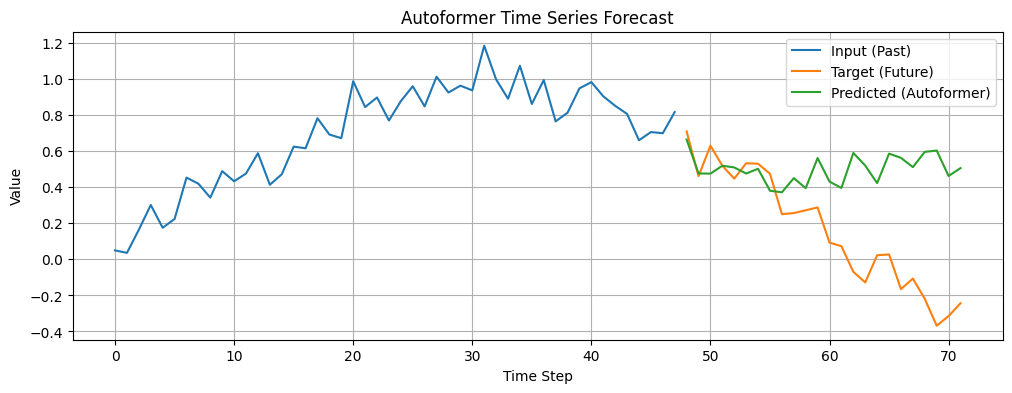

In [17]:
model.eval()
with torch.no_grad():
    sample_x = X_tensor[0].unsqueeze(0)  # (1, 48, 1)
    sample_y = y_tensor[0].squeeze(0).cpu().numpy()  # (24, 1)
    pred_y = model(sample_x).squeeze(0).cpu().numpy()  # (24, 1)

    # concat + 역정규화
    full_input = np.concatenate([sample_x.squeeze(0).cpu().numpy(), sample_y], axis=0)  # (72, 1)
    full_pred  = np.concatenate([sample_x.squeeze(0).cpu().numpy(), pred_y], axis=0)   # (72, 1)

    full_input = scaler.inverse_transform(full_input)
    full_pred  = scaler.inverse_transform(full_pred)

    # 다시 분할
    input_original     = full_input[:input_window].squeeze()       # (48,)
    target_original    = full_input[input_window:].squeeze()       # (24,)
    predicted_original = full_pred[input_window:].squeeze()        # (24,)

# 시각화
x_input = range(input_window)
x_target = range(input_window, input_window + output_window)

plt.figure(figsize=(12, 4))
plt.plot(x_input, input_original, label='Input (Past)')
plt.plot(x_target, target_original, label='Target (Future)')
plt.plot(x_target, predicted_original, label='Predicted (Autoformer)')
plt.title("Autoformer Time Series Forecast")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# save and show
plt.savefig("sin_result/Autoformer_sin_function_forecast.png", bbox_inches='tight')
plt.show()

### END